In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

# Import your custom solver module.
# Replace the following import with the actual location of solve_nivp.
# For example, if your module is in the same directory, you might do:
# from solve_nivp import solve_ivp_ns
import solve_nivp  # Ensure that this module is in your PYTHONPATH

In [2]:

# -------------------------
# Super–twisting (nonsmooth)
# State: y = [x, v, nu, s, w]
#  - x, v: plant states
#  - nu: controller integral state
#  - s: sliding variable s = c1 x + c2 v (algebraic row in A)
#  - w: selection with w ∈ sign(s) enforced by projection (algebraic row)
# -------------------------
c1, c2 = 1.0, 1.0            # sliding surface s = c1 x + c2 v
L = 0.3*5
k1, k2 = 1.5*np.sqrt(L), 1.1*L            # STC gains (see note above)
T      = 6
t_span = (0.0, T)

x0, v0 = 0.5, 0.0            # initial condition
nu0    = 0.0                 # integral state
s0     = c1*x0 + c2*v0
w0     = 1.0 if s0>0 else (-1.0 if s0<0 else 0.0)
h0=1e-3

In [3]:
# bounded disturbance
def d(t):
    return 0.3*np.sin(5*t) 

# ---- residual for A ydot - f = 0 ----
# State: y = [x, v, nu, s, w]
def rhs(t, y, Fk=None):
    x, v, nu, s, w = y
    s = c1*x + c2*v  # recompute s to avoid drift
    u   = -k1*np.sqrt(abs(s))*w + nu
    f0  = v                 # xdot
    f1  = u + d(t)          # vdot
    f2  = -k2*w             # nudot
    f3  = s - (c1*x + c2*v) # algebraic constraint for s
    f4  = 0.0               # w handled by projection
    return np.array([f0, f1, f2, f3, f4])

# Optional analytic Jacobian (helps SSN, not required for VI)
def rhs_jac(t, y, Fk=None):
    x, v, nu, s, w = y
    J = np.zeros((5,5))
    # u = -k1*|s|^{1/2}*w + nu
    du_ds = (-0.5*k1*w*np.sign(s)/np.sqrt(abs(s))) if s != 0.0 else 0.0
    du_dnu = 1.0
    du_dw  = -k1*np.sqrt(abs(s)) if s != 0.0 else 0.0
    # row xdot = v
    J[0,1] = 1.0
    # row vdot = u + d(t)
    J[1,2] = du_dnu
    J[1,3] = du_ds
    J[1,4] = du_dw
    # row nudot = -k2*w
    J[2,4] = -k2
    # row s - (c1 x + c2 v) = 0
    J[3,0] = -c1; 
    J[3,1] = -c2; 
    J[3,3] = 1.0
    return J

# ---- mass matrix: make s and w algebraic ----
A = np.eye(5)
A[3,:] = 0.0   # s row algebraic
A[4,:] = 0.0   # w row algebraic




In [4]:
# # Projection: enforce w ∈ sign(s)
# from solve_nivp.projections import SignProjection
# proj = SignProjection(y_indices=[3], w_indices=[4])

# Options for high-level API
projection_opts = dict(y_indices=[3], w_indices=[4])

# Time span and component slices for high-level call
t_span = (0.0, T)
component_slices = [slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)]

# Common nonlinear-solver options
solver_opts_common = dict(
    tol=1e-4,
    max_iter=100,
    lam=1.0,
    rhs_jac=rhs_jac,      # enables exact residual Jacobian in integrators
)


# Adaptive controller options passed via high-level API
adaptive_opts = dict(
    h0=h0,
    h_min=1e-8,
    h_down=0.5, h_up=1.5,
    method_order=1,           # conservative order for nonsmooth dynamics
    use_PI=False,              # smoother steps
    skip_error_indices=[3,4]  # don't penalize algebraic/projection rows s,w
 )



In [5]:
Y0 = np.array([x0, v0, nu0, s0, w0], dtype=float)

 # -----------------------------
# Solve with semismooth Newton
# -----------------------------
tic_sn = time.time()
t_sn, y_sn, h_sn, fk_sn, info_sn = solve_nivp.solve_ivp_ns(
    fun=rhs,
    t_span=t_span,
    y0=Y0,
    method='trapezoidal',   # BE is more forgiving at nonsmooth events
    projection='sign',
    solver='semismooth_newton',
    projection_opts=projection_opts,
    solver_opts=solver_opts_common,
    adaptive=True,
    adaptive_opts=adaptive_opts,         # tuned above
    atol=1e-6,
    rtol=1e-3,
    h0=h0,
    component_slices=component_slices,
    verbose=True,
    A=A
)
toc_sn = time.time() - tic_sn
print(f"SSN solve OK in {toc_sn:.3f}s, steps={len(t_sn)-1}, last h={h_sn[-1]:.3e}")

[adaptive] reject @ t=0.257493, E=1.578e+00 ⇒ h -> 9.294e-02
[adaptive] reject @ t=0.350436, E=9.194e+01 ⇒ h -> 6.573e-02
[adaptive] reject @ t=0.350436, E=1.533e+00 ⇒ h -> 4.777e-02
[adaptive] reject @ t=0.398208, E=4.590e+01 ⇒ h -> 3.140e-02
[adaptive] reject @ t=0.398208, E=2.195e+01 ⇒ h -> 1.570e-02
[adaptive] reject @ t=0.41391, E=9.992e+00 ⇒ h -> 1.178e-02
[adaptive] reject @ t=0.41391, E=3.865e+00 ⇒ h -> 5.888e-03
[adaptive] reject @ t=0.854868, E=1.221e+00 ⇒ h -> 1.398e-01
[adaptive] reject @ t=0.994699, E=1.130e+00 ⇒ h -> 1.151e-01
[adaptive] reject @ t=1.10983, E=7.227e+01 ⇒ h -> 6.616e-02
[adaptive] reject @ t=1.17599, E=5.072e+01 ⇒ h -> 3.200e-02
[adaptive] reject @ t=1.20799, E=1.666e+01 ⇒ h -> 1.611e-02
[adaptive] reject @ t=1.20799, E=7.049e+00 ⇒ h -> 8.054e-03
[adaptive] reject @ t=1.20799, E=1.382e+00 ⇒ h -> 6.167e-03
[adaptive] reject @ t=1.45614, E=1.343e+00 ⇒ h -> 9.982e-02
[adaptive] reject @ t=1.66308, E=5.939e+01 ⇒ h -> 5.001e-02
[adaptive] reject @ t=1.71308, E=

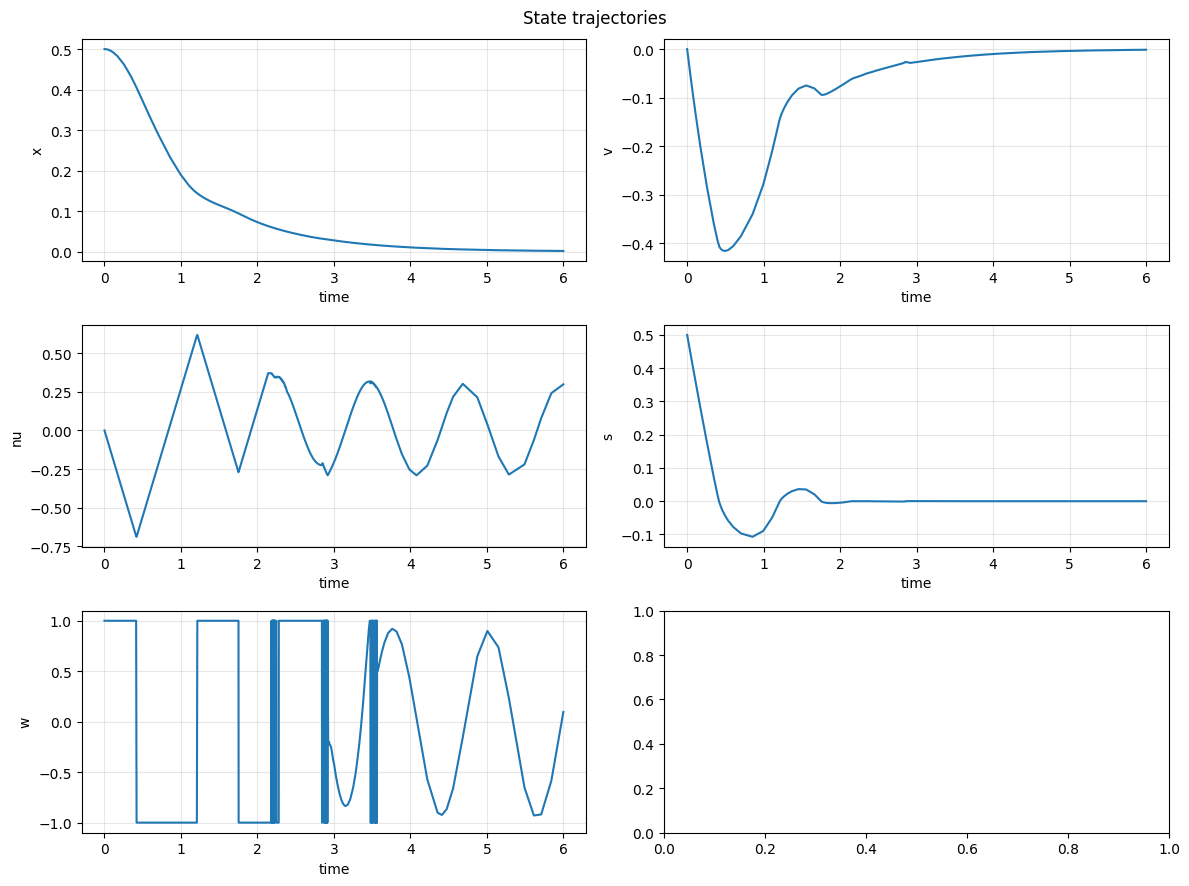

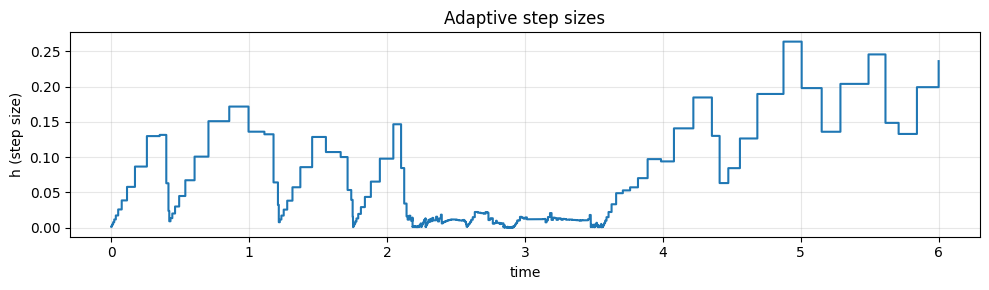

In [6]:
# Post-processing: plot states, step sizes, residual norms, and iterations
import numpy as np
import matplotlib.pyplot as plt

def _ensure_TY(t, y):
    arr = np.asarray(y)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[0] != len(t) and arr.shape[1] == len(t):
        arr = arr.T
    return arr

def _safe_norm(x):
    try:
        a = np.asarray(x)
        return float(np.linalg.norm(a))
    except Exception:
        try:
            return float(x)
        except Exception:
            return np.nan

# Ensure variables exist
try:
    t = np.asarray(t_sn)
    Y = _ensure_TY(t_sn, y_sn)
    H = np.asarray(h_sn) if 'h_sn' in globals() else None
    FK = fk_sn if 'fk_sn' in globals() else None
    INFO = info_sn if 'info_sn' in globals() else None
except NameError as e:
    raise RuntimeError("Run the high-level solve cell first to populate t_sn, y_sn, h_sn, fk_sn, info_sn.") from e

# 1) Plot all states
n_states = Y.shape[1]
default_labels = ['x','v','nu','s','w']
labels = [default_labels[i] if i < len(default_labels) and n_states == 5 else f'y[{i}]' for i in range(n_states)]

rows = int(np.ceil(n_states/2))
cols = 2 if n_states > 1 else 1
fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows), squeeze=False)
for i in range(n_states):
    r, c = divmod(i, cols)
    ax = axes[r][c]
    ax.plot(t, Y[:, i], label=labels[i])
    ax.set_xlabel('time')
    ax.set_ylabel(labels[i])
    ax.grid(True, alpha=0.3)
fig.suptitle('State trajectories')
plt.tight_layout(); plt.show()

# 2) Step size history
if H is not None and len(H) == len(t):
    plt.figure(figsize=(10,3))
    plt.step(t, H, where='post')
    plt.xlabel('time'); plt.ylabel('h (step size)')
    plt.title('Adaptive step sizes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

# 3) Residual norm per accepted step
if FK is not None:
    try:
        res_norms = np.array([_safe_norm(r) for r in FK])
        if len(res_norms) == len(t):
            plt.figure(figsize=(10,3))
            plt.semilogy(t, res_norms, '-')
            plt.xlabel('time'); plt.ylabel('||F_k||')
            plt.title('Implicit residual norm per step')
            plt.grid(True, which='both', alpha=0.3)
            plt.tight_layout(); plt.show()
    except Exception:
        pass

# 4) Nonlinear iterations per step (if available)
if INFO is not None:
    try:
        iters = []
        for item in INFO:
            if isinstance(item, (list, tuple)) and len(item) >= 3:
                iters.append(item[2])
            else:
                iters.append(np.nan)
        iters = np.asarray(iters, dtype=float)
        if len(iters) == len(t):
            plt.figure(figsize=(10,3))
            plt.step(t, iters, where='post')
            plt.xlabel('time'); plt.ylabel('iterations')
            plt.title('Nonlinear iterations per accepted step')
            plt.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()
            # Quick summary
            try:
                print(f"Accepted steps: {len(t)-1}, avg iters/step: {np.nanmean(iters[1:]):.2f}, final h={H[-1]:.3e}")
            except Exception:
                pass
    except Exception:
        pass

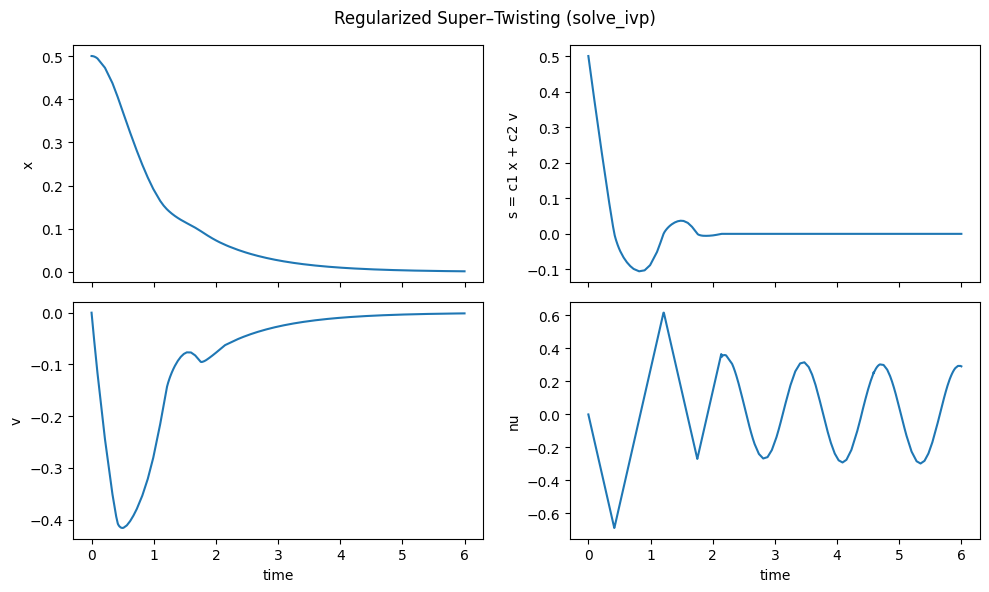

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ---------------------------
# Plant:  xdot = v
#         vdot = u + d(t)
# Sliding variable: s = c1*x + c2*v
# Super-twisting (regularized):
#   u   = -k1 * |s|^{1/2}_eps * sign_eps(s) + nu
#   nudot = -k2 * sign_eps(s)
# ---------------------------

# Controller/plant params (pick reasonable positive values)
# k1, k2 = 2.0, 1.5
c1, c2 = 1.0, 1.0

# Small regularization (bigger => smoother, easier for solver; smaller => closer to ideal)
eps = 1e-10

def sign_eps(s, eps):
    # smooth sign: C^∞, bounded slope near 0
    return s / np.sqrt(s*s + eps*eps)

def sqrtabs_eps(s, eps):
    # smooth |s|^{1/2} ≈ (s^2 + eps^2)^{1/4}
    return (s*s + eps*eps)**0.25

# def disturbance(t):
#     # try a bounded irritation to see robustness
#     return 0.3*np.sin(5*t) + 0.2*np.tanh(20*np.sin(17*t))

# State: y = [x, v, nu]
def sta_rhs_reg(t, y):
    x, v, nu = y
    s   = c1*x + c2*v
    sgn = sign_eps(s, eps)
    root = sqrtabs_eps(s, eps)
    u   = -k1 * root * sgn + nu
    xdot = v
    vdot = u + d(t)
    nudot = -k2 * sgn
    return np.array([xdot, vdot, nudot])



# ---- simulate with solve_ivp ----
t0, tf = 0.0, T
y0 = np.array([0.5, 0.0, 0.0])   # start off the surface
sol = solve_ivp(
    sta_rhs_reg, (t0, tf), y0,
    method="BDF",              # stiff-friendly when eps is small
    rtol=1e-3, atol=1e-6
)

t = sol.t
x, v, nu = sol.y
s = c1*x + c2*v

# ---- plots ----
fig, ax = plt.subplots(2,2, figsize=(10,6), sharex="col")
ax[0,0].plot(t, x);  ax[0,0].set_ylabel("x")
ax[1,0].plot(t, v);  ax[1,0].set_ylabel("v"); ax[1,0].set_xlabel("time")
ax[0,1].plot(t, s);  ax[0,1].set_ylabel("s = c1 x + c2 v")
ax[1,1].plot(t, nu); ax[1,1].set_ylabel("nu"); ax[1,1].set_xlabel("time")
fig.suptitle("Regularized Super–Twisting (solve_ivp)")
plt.tight_layout(); plt.show()


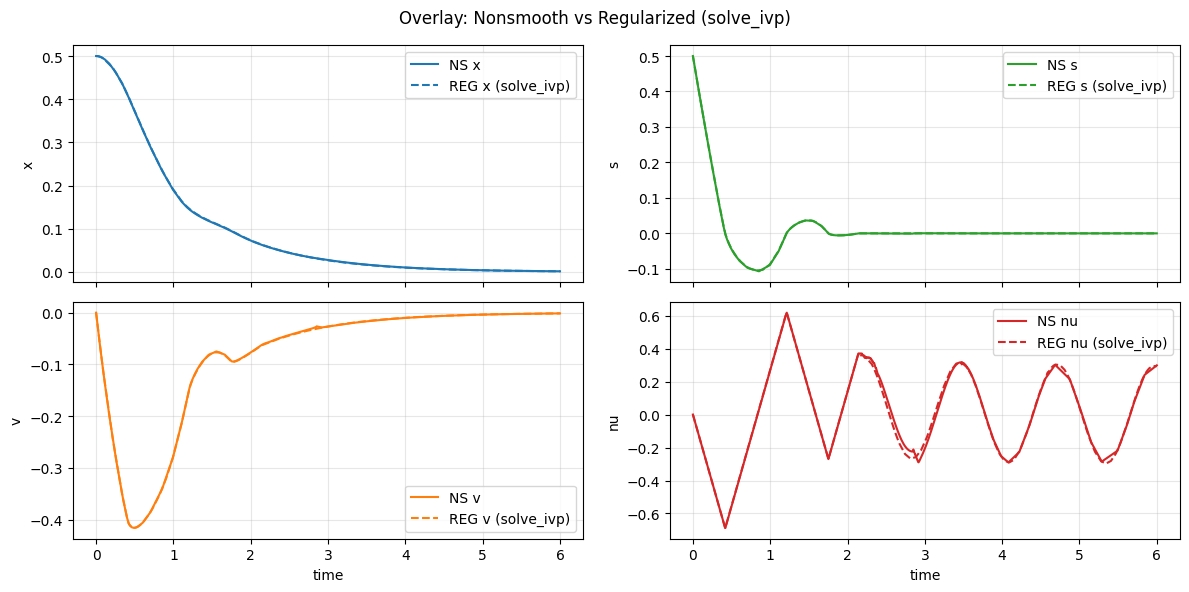

In [8]:
# Overlay: nonsmooth (NS) vs regularized (solve_ivp)
import numpy as np
import matplotlib.pyplot as plt

missing = []
try:
    t_ns = np.asarray(t_sn)
    Y_ns = np.asarray(y_sn)
except NameError:
    missing.append('nonsmooth high-level solve (t_sn, y_sn)')
try:
    t_reg = np.asarray(t)  # from solve_ivp block
    x_reg = np.asarray(x); v_reg = np.asarray(v); nu_reg = np.asarray(nu)
except NameError:
    missing.append('regularized solve_ivp run (t, x, v, nu)')

if missing:
    print('Please run the following before overlay:')
    for m in missing:
        print(' -', m)
else:
    # Extract NS signals
    x_ns  = Y_ns[:, 0]
    v_ns  = Y_ns[:, 1]
    nu_ns = Y_ns[:, 2]
    s_ns  = Y_ns[:, 3] if Y_ns.shape[1] >= 4 else (c1*x_ns + c2*v_ns)
    # Regularized s
    s_reg = c1 * x_reg + c2 * v_reg

    fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex='col')
    # x
    ax[0,0].plot(t_ns, x_ns, 'C0-',  label='NS x')
    ax[0,0].plot(t_reg, x_reg, 'C0--', label='REG x (solve_ivp)')
    ax[0,0].set_ylabel('x'); ax[0,0].grid(True, alpha=0.3); ax[0,0].legend()
    # v
    ax[1,0].plot(t_ns, v_ns, 'C1-',  label='NS v')
    ax[1,0].plot(t_reg, v_reg, 'C1--', label='REG v (solve_ivp)')
    ax[1,0].set_ylabel('v'); ax[1,0].set_xlabel('time'); ax[1,0].grid(True, alpha=0.3); ax[1,0].legend()
    # s
    ax[0,1].plot(t_ns, s_ns, 'C2-',  label='NS s')
    ax[0,1].plot(t_reg, s_reg, 'C2--', label='REG s (solve_ivp)')
    ax[0,1].set_ylabel('s'); ax[0,1].grid(True, alpha=0.3); ax[0,1].legend()
    # nu
    ax[1,1].plot(t_ns, nu_ns, 'C3-',  label='NS nu')
    ax[1,1].plot(t_reg, nu_reg, 'C3--', label='REG nu (solve_ivp)')
    ax[1,1].set_ylabel('nu'); ax[1,1].set_xlabel('time'); ax[1,1].grid(True, alpha=0.3); ax[1,1].legend()
    fig.suptitle('Overlay: Nonsmooth vs Regularized (solve_ivp)')
    plt.tight_layout(); plt.show()

Failed integration: reached minimum step size at t=0.41684 and step did not converge.


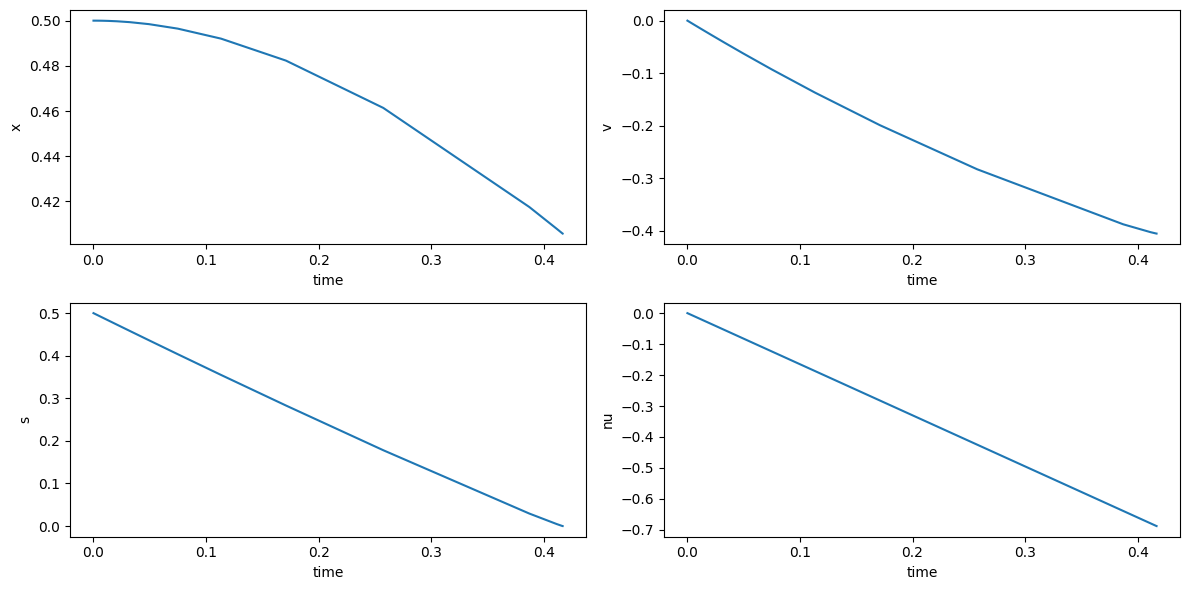

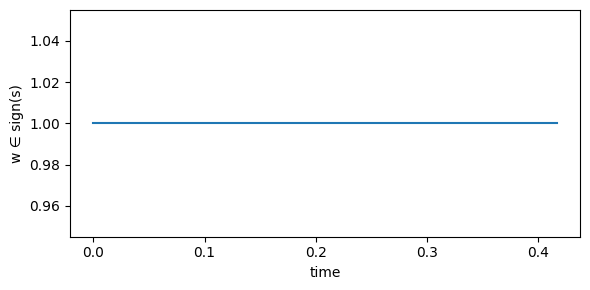

In [31]:
# -------------------------
# Wire into framework
# -------------------------
from solve_nivp.projections import SignProjection
from solve_nivp.nonlinear_solvers import ImplicitEquationSolver
from solve_nivp.integrations import CompositeMethod
from solve_nivp.ODESystem import ODESystem
from solve_nivp.ODESolver import ODESolver
from solve_nivp.adaptive_integrator import AdaptiveStepping

# Projection: enforce w ∈ sign(s)
proj = SignProjection(y_indices=[3], w_indices=[4])

# Prefer Semismooth Newton here for speed; retains projection rigor
solver = ImplicitEquationSolver(
    method='semismooth_newton',
    proj=proj,
    component_slices=[slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)],
    tol=1e-8,
    max_iter=60,
    lam=1.0,
    globalization='linesearch',  # Armijo on merit function
    ls_beta=0.5,
    ls_c1=1e-4,
    max_backtracks=20,
)
# Attach optional analytic Jacobian
solver.rhs_jacobian = rhs_jac

method = CompositeMethod(solver=solver, A=A)

# Adaptive controller; skip LTE on algebraic/projection coords (s,w)
adaptive = AdaptiveStepping(
    integrator=method,
    component_slices=[slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)],
    h0=h0, h_min=1e-8, h_down=0.5, h_up=1.5,
    use_PI=True,
    skip_error_indices=[3,4]
)

# Initial state aligned with rhs ordering [x, v, nu, s, w]
# Y0 = np.array([x0, v0, nu0, s0, w0], dtype=float)

system = ODESystem(
    fun=rhs,
    y0=Y0,
    method=method,
    adaptive=True,
    component_slices=[slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)],
    atol=1e-6, rtol=1e-3, verbose=True,
    A=A
)
system.adaptive_stepper = adaptive

solver_instance = ODESolver(system, (0.0, T), h0)
t, Y, h_hist, *_ = solver_instance.solve()

x, v, nu, s, w = Y.T

plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plt.plot(t, x);  plt.xlabel('time'); plt.ylabel('x')
plt.subplot(2,2,2); plt.plot(t, v);  plt.xlabel('time'); plt.ylabel('v')
plt.subplot(2,2,3); plt.plot(t, s);  plt.xlabel('time'); plt.ylabel('s')
plt.subplot(2,2,4); plt.plot(t, nu); plt.xlabel('time'); plt.ylabel('nu')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.step(t, w, where='post'); plt.xlabel('time'); plt.ylabel('w ∈ sign(s)')
plt.tight_layout(); plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Semismooth Newton (globalized) for the same STA system
from solve_nivp.nonlinear_solvers import ImplicitEquationSolver
from solve_nivp.integrations import CompositeMethod
from solve_nivp.ODESystem import ODESystem
from solve_nivp.ODESolver import ODESolver

# Reuse rhs, rhs_jac, A, proj, Y0 from the previous cell
h_ssn = 1e-4
T_ssn = 10.0 if 'T' not in globals() else T

solver_ssn = ImplicitEquationSolver(
    method='semismooth_newton',
    proj=proj,
    component_slices=[slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)],
    tol=1e-8,
    max_iter=100,
    lam=1.0,
)

# Attach optional analytic Jacobian
try:
    solver_ssn.rhs_jacobian = rhs_jac
except Exception:
    pass

# Try to enable line-search globalization if available on this solver
for name, val in [
    ('line_search', True),
    ('ls_armijo', True),
    ('ls_beta', 0.5),
    ('ls_c', 1e-4),
    ('ls_max_backtracks', 20),
]:
    if hasattr(solver_ssn, name):
        setattr(solver_ssn, name, val)

method_ssn = CompositeMethod(solver=solver_ssn, A=A)

system_ssn = ODESystem(
    fun=rhs,
    y0=Y0,
    method=method_ssn,
    adaptive=True,
    component_slices=[slice(0,1), slice(1,2), slice(2,3), slice(3,4), slice(4,5)],
    atol=1e-6,
    rtol=1e-3,
    verbose=True,
    A=A,
)

solver_instance_ssn = ODESolver(system_ssn, (0.0, T_ssn), h_ssn)
t_ssn, Y_ssn, h_hist_ssn, *_ = solver_instance_ssn.solve()

x_s, v_s, nu_s, s_s, w_s = Y_ssn.T

# Plots
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.plot(t_ssn, x_s); plt.xlabel('time'); plt.ylabel('x (SSN)')
plt.subplot(1,3,2); plt.plot(t_ssn, s_s); plt.xlabel('time'); plt.ylabel('s (SSN)')
plt.subplot(1,3,3); plt.plot(t_ssn, v_s); plt.xlabel('time'); plt.ylabel('v (SSN)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.step(t_ssn, w_s, where='post'); plt.xlabel('time'); plt.ylabel('w ∈ sign(s) (SSN)')
plt.tight_layout(); plt.show()

[adaptive] reject @ t=0.2047, E=1.764e+00 ⇒ h -> 2.501e-01
[adaptive] reject @ t=0.37253, E=1.304e+00 ⇒ h -> 4.995e-02
[adaptive] reject @ t=0.37253, E=8.510e+00 ⇒ h -> 2.633e-02
[adaptive] reject @ t=0.398857, E=1.139e+00 ⇒ h -> 3.131e-02
[adaptive] reject @ t=0.80849, E=1.684e+00 ⇒ h -> 2.486e-01
[adaptive] reject @ t=0.80849, E=1.677e+00 ⇒ h -> 1.850e-01
[adaptive] reject @ t=1.21313, E=4.856e+00 ⇒ h -> 8.167e-03
[adaptive] reject @ t=1.21313, E=3.371e+00 ⇒ h -> 4.484e-03
[adaptive] reject @ t=1.21313, E=2.065e+00 ⇒ h -> 2.898e-03
[adaptive] reject @ t=1.21313, E=1.395e+00 ⇒ h -> 2.191e-03
[adaptive] reject @ t=1.21313, E=1.060e+00 ⇒ h -> 1.861e-03
[adaptive] reject @ t=1.54337, E=2.523e+00 ⇒ h -> 1.361e-01
[adaptive] reject @ t=1.71518, E=4.287e+00 ⇒ h -> 4.479e-02
[adaptive] reject @ t=1.73758, E=1.928e+00 ⇒ h -> 2.048e-02
[adaptive] reject @ t=1.73758, E=2.637e+00 ⇒ h -> 1.347e-02
[adaptive] reject @ t=1.75105, E=6.978e+00 ⇒ h -> 6.185e-03
[adaptive] reject @ t=1.75105, E=3.905e+

KeyboardInterrupt: 